In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plots

## Synchronous SGD

Synchronous training time: 02:30:051


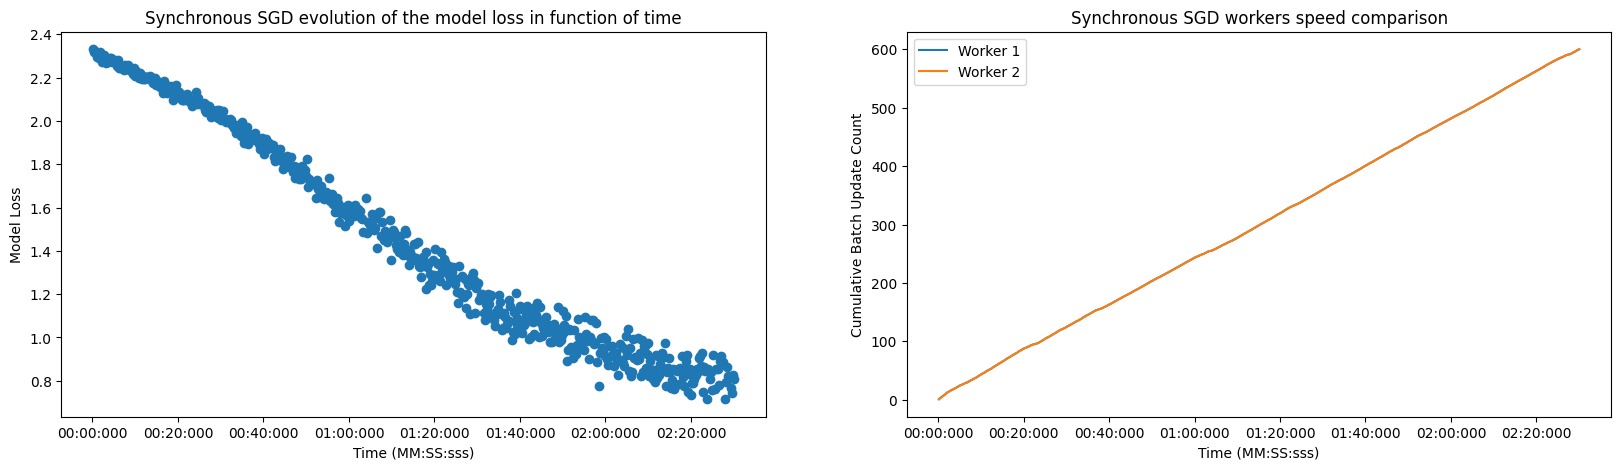

In [2]:
lines = []
with open("log_sync.log", "r") as log_file:
    # Iterate through each line in the log file
    for line in log_file:
        lines.append(line.split(" - __mp_main__ - "))

for i, line in enumerate(lines):
    timestamp = datetime.strptime(line[0], "%Y-%m-%d %H:%M:%S,%f")
    lines[i][0] = timestamp

nb_workers = int(
    (lines[0][1].split("with ")[1]).split(" workers")[0]
)  # extract from first line
lines = lines[1:-1]  # remove first and last lines (info messages)

start_time = lines[0][0]
end_time = lines[-1][0]
training_time_sync = end_time - start_time

minutes, remainder = divmod(training_time_sync.seconds, 60)
seconds = remainder
milliseconds = training_time_sync.microseconds // 1000
formatted_training_time_sync = f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"
print("Synchronous training time:", formatted_training_time_sync)  # MM:SS:sss

for i, line in enumerate(lines):
    lines[i][0] = line[0] - start_time
    lines[i][1] = line[1].split("DEBUG - ")[1].strip()

model_loss_lines = []
worker_update_lines = []
for i, line in enumerate(lines):
    if i < nb_workers:
        continue
    if "PS updated model, " in line[1]:
        # timedetla, model loss
        model_loss_lines.append((line[0], float(line[1].split("is ")[1])))
    elif "PS got " in line[1]:
        splited_text = (line[1].split("from ")[1]).split(" ")
        # timedelta, worker id, batch count, epoch
        worker_update_lines.append(
            (
                line[0],
                int(splited_text[0].split("_")[1][:-1]),
                int(splited_text[2].split("/")[0][1:]),
                int(splited_text[-1].split("/")[0]),
            )
        )


####### PLOTS #######
def format_timedelta(x, pos):
    td = timedelta(seconds=x)
    minutes, remainder = divmod(td.seconds, 60)
    seconds = remainder
    milliseconds = td.microseconds // 1000
    return f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"


# Create a 1x2 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# First subplot (Model Loss vs Time)
timedeltas = [line[0].total_seconds() for line in model_loss_lines]
losses = [line[1] for line in model_loss_lines]

axs[0].scatter(timedeltas, losses, marker="o")
axs[0].set_xlabel("Time (MM:SS:sss)")
axs[0].set_ylabel("Model Loss")
axs[0].set_title("Synchronous SGD evolution of the model loss in function of time")

# Format x-axis tick labels
formatter = FuncFormatter(format_timedelta)
axs[0].xaxis.set_major_formatter(formatter)

# Second subplot (Cumulative Batch Update Count vs Time)
worker_cumulative_updates = {}
for line in worker_update_lines:
    td, worker_id, batch_count, epoch = line
    worker_cumulative_updates.setdefault(worker_id, []).append((td, batch_count))

for worker_id, updates in worker_cumulative_updates.items():
    x = [td.total_seconds() for td, _ in updates]
    y = [batch_count for _, batch_count in updates]
    axs[1].plot(x, y, label=f"Worker {worker_id}")

axs[1].set_xlabel("Time (MM:SS:sss)")
axs[1].set_ylabel("Cumulative Batch Update Count")
axs[1].set_title("Synchronous SGD workers speed comparison")
axs[1].legend()

# Format x-axis tick labels
axs[1].xaxis.set_major_formatter(formatter)

# Display the subplots
plt.show()

## Asynchronous SGD

Asynchronous training time: 02:29:831


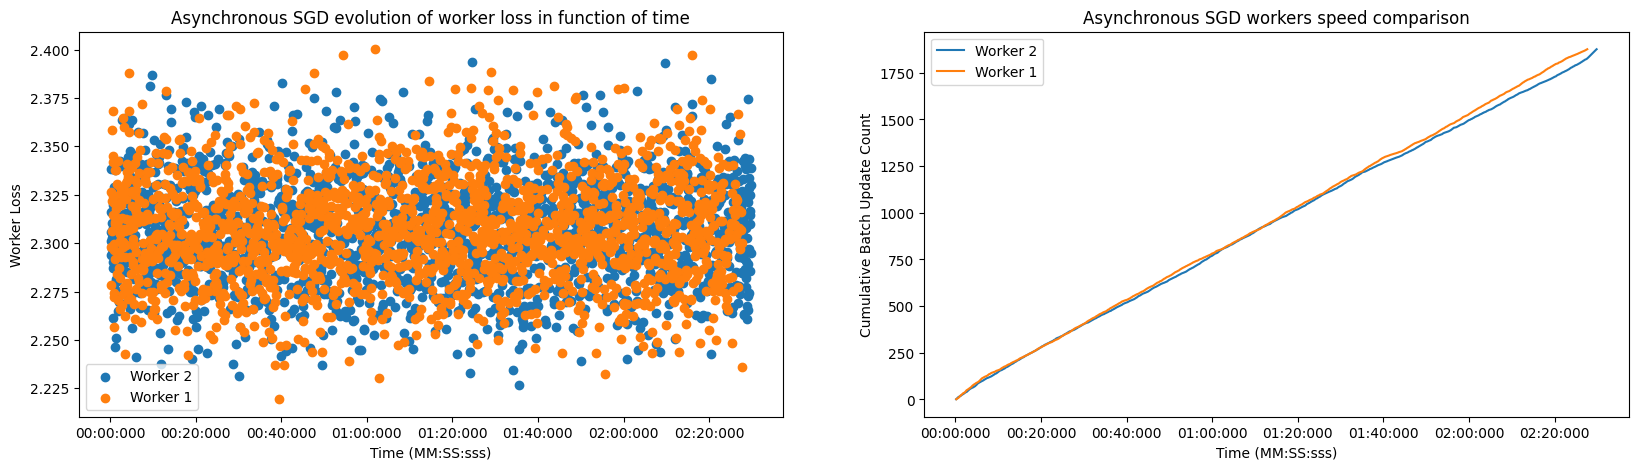

In [3]:
lines = []
with open("log_async.log", "r") as log_file:
    # Iterate through each line in the log file
    for line in log_file:
        lines.append(line.split(" - __mp_main__ - "))

for i, line in enumerate(lines):
    timestamp = datetime.strptime(line[0], "%Y-%m-%d %H:%M:%S,%f")
    lines[i][0] = timestamp

nb_workers = int(
    (lines[0][1].split("with ")[1]).split(" workers")[0]
)  # extract from first line
lines = lines[1:-1]  # remove first and last lines (info messages)

start_time = lines[0][0]
end_time = lines[-1][0]
training_time_async = end_time - start_time

minutes, remainder = divmod(training_time_async.seconds, 60)
seconds = remainder
milliseconds = training_time_async.microseconds // 1000
formatted_training_time_async = f"{minutes:02d}:{seconds:02d}:{milliseconds:03d}"
print("Asynchronous training time:", formatted_training_time_async)  # MM:SS:sss

for i, line in enumerate(lines):
    lines[i][0] = line[0] - start_time
    lines[i][1] = line[1].split("DEBUG - ")[1].strip()

worker_update_lines = []
for i, line in enumerate(lines):
    if i < nb_workers:
        continue
    if "PS updated model, worker loss: " in line[1]:
        splited_text = (line[1].split("PS updated model, worker loss: "))[1].split(" ")
        worker_update_lines.append(
            (line[0], float(splited_text[0]), int(splited_text[1].split("_")[1][:-1]))
        )


####### PLOTS #######
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# First subplot (Worker Loss vs Time)
worker_losses = {}
for line in worker_update_lines:
    td, worker_loss, worker_id = line
    worker_losses.setdefault(worker_id, []).append((td, worker_loss))

for worker_id, losses in worker_losses.items():
    x = [td.total_seconds() for td, _ in losses]
    y = [worker_loss for _, worker_loss in losses]
    axs[0].scatter(x, y, label=f"Worker {worker_id}", marker="o")

axs[0].set_xlabel("Time (MM:SS:sss)")
axs[0].set_ylabel("Worker Loss")
axs[0].set_title("Asynchronous SGD evolution of worker loss in function of time")
axs[0].legend()

# Format x-axis tick labels
formatter = FuncFormatter(format_timedelta)
axs[0].xaxis.set_major_formatter(formatter)

# Second subplot (Cumulative Batch Update Count vs Time)
worker_cumulative_updates = {}
for line in worker_update_lines:
    td, _, worker_id = line
    worker_cumulative_updates.setdefault(worker_id, []).append(td)

for worker_id, updates in worker_cumulative_updates.items():
    x = [td.total_seconds() for td in updates]
    y = list(range(1, len(updates) + 1))
    axs[1].plot(
        x,
        y,
        label=f"Worker {worker_id}",
    )

axs[1].set_xlabel("Time (MM:SS:sss)")
axs[1].set_ylabel("Cumulative Batch Update Count")
axs[1].set_title("Asynchronous SGD workers speed comparison")
axs[1].legend()

# Format x-axis tick labels
axs[1].xaxis.set_major_formatter(formatter)

# Display the subplots
plt.show()

# Train/Test Performance

## Synchronous SGD

In [4]:
!python test_model.py mnist_sync_3_05_0001_00_100_2.pt

usage: test_model.py [-h] [--batch_size BATCH_SIZE] model_path
test_model.py: error: argument model_path: can't open 'mnist_sync_3_05_0001_00_100_2.pt': [Errno 2] No such file or directory: 'mnist_sync_3_05_0001_00_100_2.pt'


## Asynchronous SGD

In [5]:
!python test_model.py mnist_async_3_05_0001_00_100_2.pt

Using default batch_size: 500
Loading MNIST CNN

Train Performance
Created MNIST trainloader 

Average train accuracy: 10.01 % (6003/60000)
Average train loss: 2.2944

Classification train report:
              precision    recall  f1-score   support

           0       0.10      0.00      0.00      5923
           1       0.00      0.00      0.00      6742
           2       0.78      0.00      0.00      5958
           3       0.10      0.85      0.19      6131
           4       0.04      0.03      0.03      5842
           5       0.05      0.00      0.00      5421
           6       0.15      0.04      0.06      5918
           7       0.21      0.05      0.08      6265
           8       0.04      0.01      0.01      5851
           9       0.01      0.00      0.00      5949

    accuracy                           0.10     60000
   macro avg       0.15      0.10      0.04     60000
weighted avg       0.15      0.10      0.04     60000

Test Performance
Created MNIST testloader 

